<a href="https://colab.research.google.com/github/YOUbhrt/DL-PROJECT/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIN LESIONS CLASSIFICATION WITH PRETRAINED DenseNet MODEL 

Importation libraries needed

In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


## Load the Data from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"younesbouhribat","key":"14db9210ac7edc3c5d4e52aefcabf378"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "nodoubttome/skin-cancer9-classesisic"


kaggle.json
100% 783M/786M [00:03<00:00, 222MB/s]
100% 786M/786M [00:03<00:00, 217MB/s]


In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

Extract Train and Test files direction

In [ ]:
DATADIR_Train = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
DATADIR_Test = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

Extract the categories of skin lession

In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATADIR_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['basal cell carcinoma', 'seborrheic keratosis', 'nevus', 'melanoma', 'actinic keratosis', 'pigmented benign keratosis', 'squamous cell carcinoma', 'vascular lesion', 'dermatofibroma']


Now let's divide the data Train and Test to X and Y(label).

In [ ]:

x_train_data = []
y_train_data = []
IMG_SIZE=224
def create_training_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
create_training_data()

In [ ]:

x_test_data = []
y_test_data = []
IMG_SIZE=224
def create_testing_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
create_testing_data()

Split the Train DATA to Train and Validation, and show the shape of eache X and Y data.

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=1)

Reshape the Dataset

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
X_Train.shape

(2015, 224, 224, 3)

In [ ]:
Y_Train.shape

(2015,)

In [ ]:
x_test_data.shape

(118, 224, 224, 3)

In [ ]:
X_Val.shape

(224, 224, 224, 3)

In [ ]:
Y_Val.shape

(224,)

To launch the Train we need to make categories from Y_Train and X_Val.

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [ ]:
Y_Train.shape

(2015, 9)

In [ ]:
Y_Val.shape

(224, 9)

In this netboke we classifie the data using a Pre-trained Model(DenseNet201).


So what is a Pre-trained Model?

> A pre-trained model is a model that has been previously trained on a dataset and contains the weights and biases that represent the features of whichever dataset it was trained on. Learned features are often transferable to different data. For example, a model trained on a large dataset of bird images will contain learned features like edges or horizontal lines that you would be transferable your dataset.




## The DenseNet201 Model





DenseNet-201 is a convolutional neural network that is 201 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

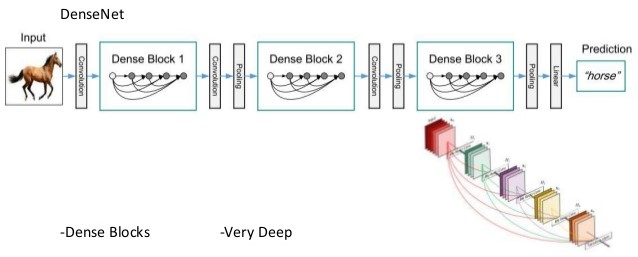


 displays the general architecture of a dense block. In a
dense block, the lth layer has l inputs, consisting of the feature-maps of all preceding convolutional blocks, and its own feature-maps are passed on to allsubsequent layers L – l. Each layer reads the state from its preceding layers and writes to the subsequent layer. It changes the state but also passes on information that needs to be preserved. Dense Net architecture explicitly differentiates between information that is added to the network and information that is preserved by concatenating features instead of summing features as in ResNet. 

### **Load in Pretrained the DenseNet201** 

In [ ]:
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

In [ ]:
IMG_SHAPE = (224, 224,3)

In [ ]:
pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


Show the layers

In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_2
zero_padding2d_2
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

Extract the last layer output.

In [ ]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1920)


### **Build the model**

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(9, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

# **Training**

Augmentation and normalization of data 




In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_Train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_Val)


In [ ]:
batch_size = 32
epochs = 15
history = model.fit_generator(train_datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_Val, Y_Val),
                              verbose = 1, steps_per_epoch=(X_Train.shape[0] // batch_size), 
                              validation_steps=(X_Val.shape[0] // batch_size))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
62/62 [==============================] - 1790s 29s/step - loss: 4.7112 - accuracy: 0.1882 - val_loss: 5783477.0000 - val_accuracy: 0.0223
Epoch 2/3
62/62 [==============================] - 1759s 28s/step - loss: 2.3677 - accuracy: 0.3103 - val_loss: 5.8518 - val_accuracy: 0.1830
Epoch 3/3
62/62 [==============================] - 1737s 28s/step - loss: 1.8591 - accuracy: 0.3785 - val_loss: 2.0442 - val_accuracy: 0.2857


## Fine Tuning Model

In [ ]:
pre_trained_model.layers[481].name

'conv5_block1_0_bn'

In [ ]:
for layer in pre_trained_model.layers[481:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
batch_size = 32
epochs = 30
history = model.fit_generator(train_datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_Val, Y_Val),
                              verbose = 1, steps_per_epoch=(X_Train.shape[0] // batch_size),
                              validation_steps=(X_Val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
62/62 [==============================] - 47s 538ms/step - loss: 1.1624 - acc: 0.6115 - val_loss: 1.0876 - val_acc: 0.6116
Epoch 2/30
62/62 [==============================] - 31s 497ms/step - loss: 1.0120 - acc: 0.6481 - val_loss: 1.0253 - val_acc: 0.6473
Epoch 3/30
62/62 [==============================] - 31s 497ms/step - loss: 0.9903 - acc: 0.6464 - val_loss: 1.0142 - val_acc: 0.6339
Epoch 4/30
62/62 [==============================] - 31s 498ms/step - loss: 0.8599 - acc: 0.6994 - val_loss: 0.9629 - val_acc: 0.6339
Epoch 5/30
62/62 [==============================] - 31s 497ms/step - loss: 0.8086 - acc: 0.7235 - val_loss: 0.9997 - val_acc: 0.6339

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/30
62/62 [==============================] - 31s 498ms/step - loss: 0.7517 - acc: 0.7169 - val_loss: 0.9274 - val_acc: 0.6696
Epoch 7/30
62/62 [==============================] - 31s 497ms/step - loss: 0.6944 - acc: 0.7425 - val_loss: 0.9091 - val_

In [ ]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 4s 141ms/step - loss: 0.9288 - acc: 0.6830
Validation: accuracy = 0.683036  ;  loss_v = 0.928754


# **Testing**

In [ ]:
y_test_data = to_categorical(y_test_data)

In [ ]:
loss_test, acc_test = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

4/4 [==============================] - 4s 526ms/step - loss: 2.2791 - acc: 0.5254
Test: accuracy = 0.525424  ;  loss = 2.279146


In [ ]:
model.save("DenseNetFT.h5")


Let's plot the each of accuracy and loss training and validation

Text(0.5, 1.0, 'Training and validation loss')

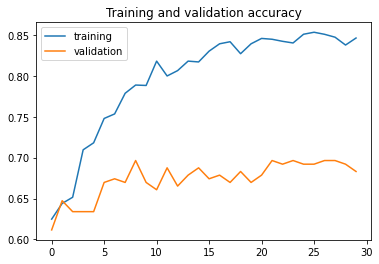

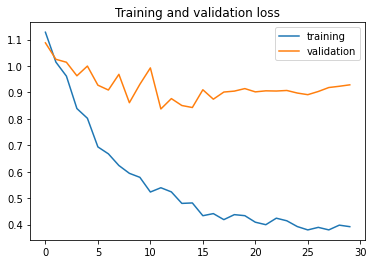

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')